## Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Importing the dataset

In [3]:
df= pd.read_csv("C:\\Users\\Sarrang\\FindDefault\\transformed_data.csv")
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

## Splitting the dataset into the Training set and Test set

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [26]:
len(df)

284807

In [27]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [28]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

lgbm = LGBMClassifier()

param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 150],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='precision', verbose=1, n_jobs=-1)

grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters found: ", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 227489, number of negative: 227454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.114935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454943, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500038 -> initscore=0.000154
[LightGBM] [Info] Start training from score 0.000154
Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'n_estimators': 150, 'num_leaves': 30, 'subsample': 0.8}


In [29]:
classifier=LGBMClassifier(colsample_bytree=0.8,
                          learning_rate=0.2,
                          n_estimators=150,
                          num_leaves=30,
                          subsample=0.8)
classifier.fit(X_train_resampled,y_train_resampled)

[LightGBM] [Info] Number of positive: 227489, number of negative: 227454
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 454943, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500038 -> initscore=0.000154
[LightGBM] [Info] Start training from score 0.000154


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.2, n_estimators=150,
               num_leaves=30, subsample=0.8)

In [30]:
y_pred=classifier.predict(X_test)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56849
           1       0.83      0.74      0.79       113

    accuracy                           1.00     56962
   macro avg       0.92      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962



In [32]:
import joblib
joblib.dump(classifier, 'lightgbm_adasyn_FD.joblib')

['lightgbm_adasyn_FD.joblib']

C:\Users\Sarrang\anaconda3\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


[[56832    17]
 [   29    84]]


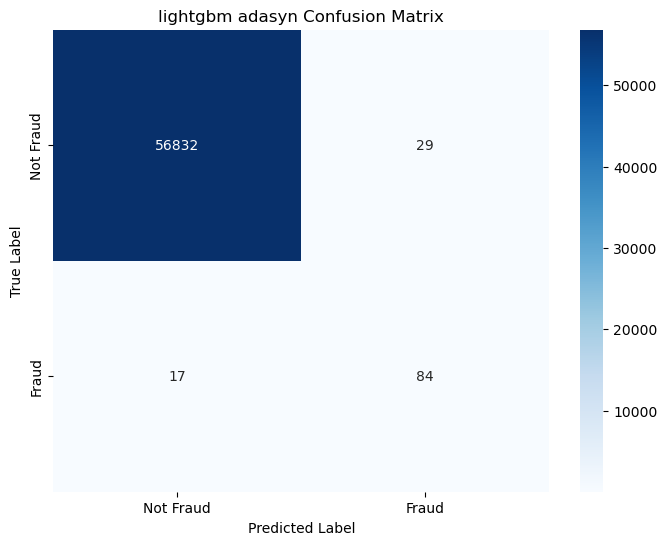

In [5]:
from joblib import load
clf=load("C:\\Users\\Sarrang\\FindDefault\\saved models\\lightgbm_adasyn_FD.joblib")
y_pred=clf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_pred,y_test))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('lightgbm adasyn Confusion Matrix')
plt.show()


In [33]:
from sklearn.metrics import roc_auc_score
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba_positive = y_pred_proba[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_positive)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.959246110151192


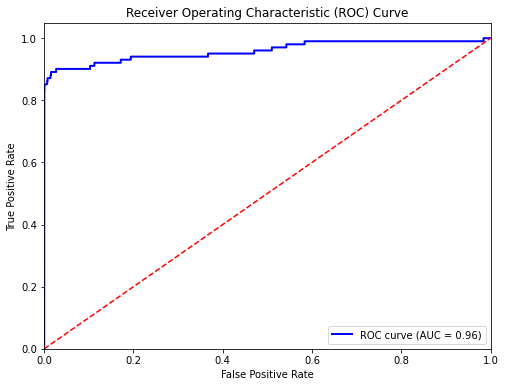

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_positive)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

feature importance